# Import modules

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [1]:
from pathlib import Path

# notebook mappa → menjünk fel a repo gyökeréhez
repo_root = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent

DATA_REPO = repo_root / "data_repository"
TIME_SERIES_DATA = DATA_REPO / "time_series"
METRICS_DATA     = DATA_REPO / "metrics"
RUNTIME_DATA     = DATA_REPO / "runtime"


# Omega Optimization

Parameters

PA1= 0.2:02:3

SEED=21, 36, 42, 79, 217

In [14]:
def get_cluster_config(n, SEED):
    return f"N-{n:0.0f}-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-{SEED:.0f}"

def get_run_name(P1, P2):
    return f"P1-{P1:0.2f}-P2-{P2:0.2f}-P3-0.00-P4-0.00"

def plot_figures(n, SEED, P1, P2):
    solution_path = TIME_SERIES_DATA / get_cluster_config(n, SEED) / get_run_name(P1, P2)
    metrics_path = METRICS_DATA / get_cluster_config(n, SEED) / get_run_name(P1, P2)
    metrics = np.load(f"{metrics_path}_jacobi_bruteforce.npz")
    solution = np.load(f"{solution_path}_jacobi_bruteforce.npz")

    with plt.style.context('ggplot'):
        _, axes = plt.subplots(2, 3, figsize=(24, 10))

        # --- Solution ---
        axes[0,0].plot(solution["time"], solution["radii"], linewidth=1)
        axes[0,0].set_xlabel('Dimensionless Time [-]')
        axes[0,0].set_ylabel('Dimensionless Radii [-]')

        axes[1,0].plot(solution["time"], solution["radii_micron"], linewidth=1)
        axes[1,0].set_xlabel('Dimensionless Time [-]')
        axes[1,0].set_ylabel('Radii [micron]')


        # --- Metrics ---
        # Opt Omega
        axes[0,1].plot(metrics["time"], metrics["omega"], linewidth=1)
        axes[0,1].set_xlabel('Dimensionless Time [-]')
        axes[0,1].set_ylabel('Relaxation Parameter [-]')

        # Iteration Number
        axes[1,1].plot(metrics["time"], metrics["iters"], linewidth=1)
        axes[1,1].set_xlabel('Dimensionless Time [-]')
        axes[1,1].set_ylabel('Iteration Nummber [-]')

        # Omega vs Rmax
        axes[0,2].plot(metrics["rmax"], metrics["omega"], linewidth=1)
        axes[0,2].set_xlabel('Max Dimensionless Radius [-]')
        axes[0,2].set_ylabel('Optimal Relaxation Parameters [-]')

        # Residuum
        axes[1,2].plot(metrics["time"], metrics["linalg_error"], linewidth=1, label=r"$||b-Ax^{k+1}||$")
        axes[1,2].plot(metrics["time"], metrics["last_stepsize"], linewidth=1, label=r"$||x^{k+1}-x^{k}||$")
        axes[1,2].set_xlabel('Dimensionless Time [-]')
        axes[1,2].set_ylabel('Absolute Error')
        axes[1,2].legend()
        axes[1,2].set_yscale('log')

    plt.show()

## PA Effect, FIX SEED

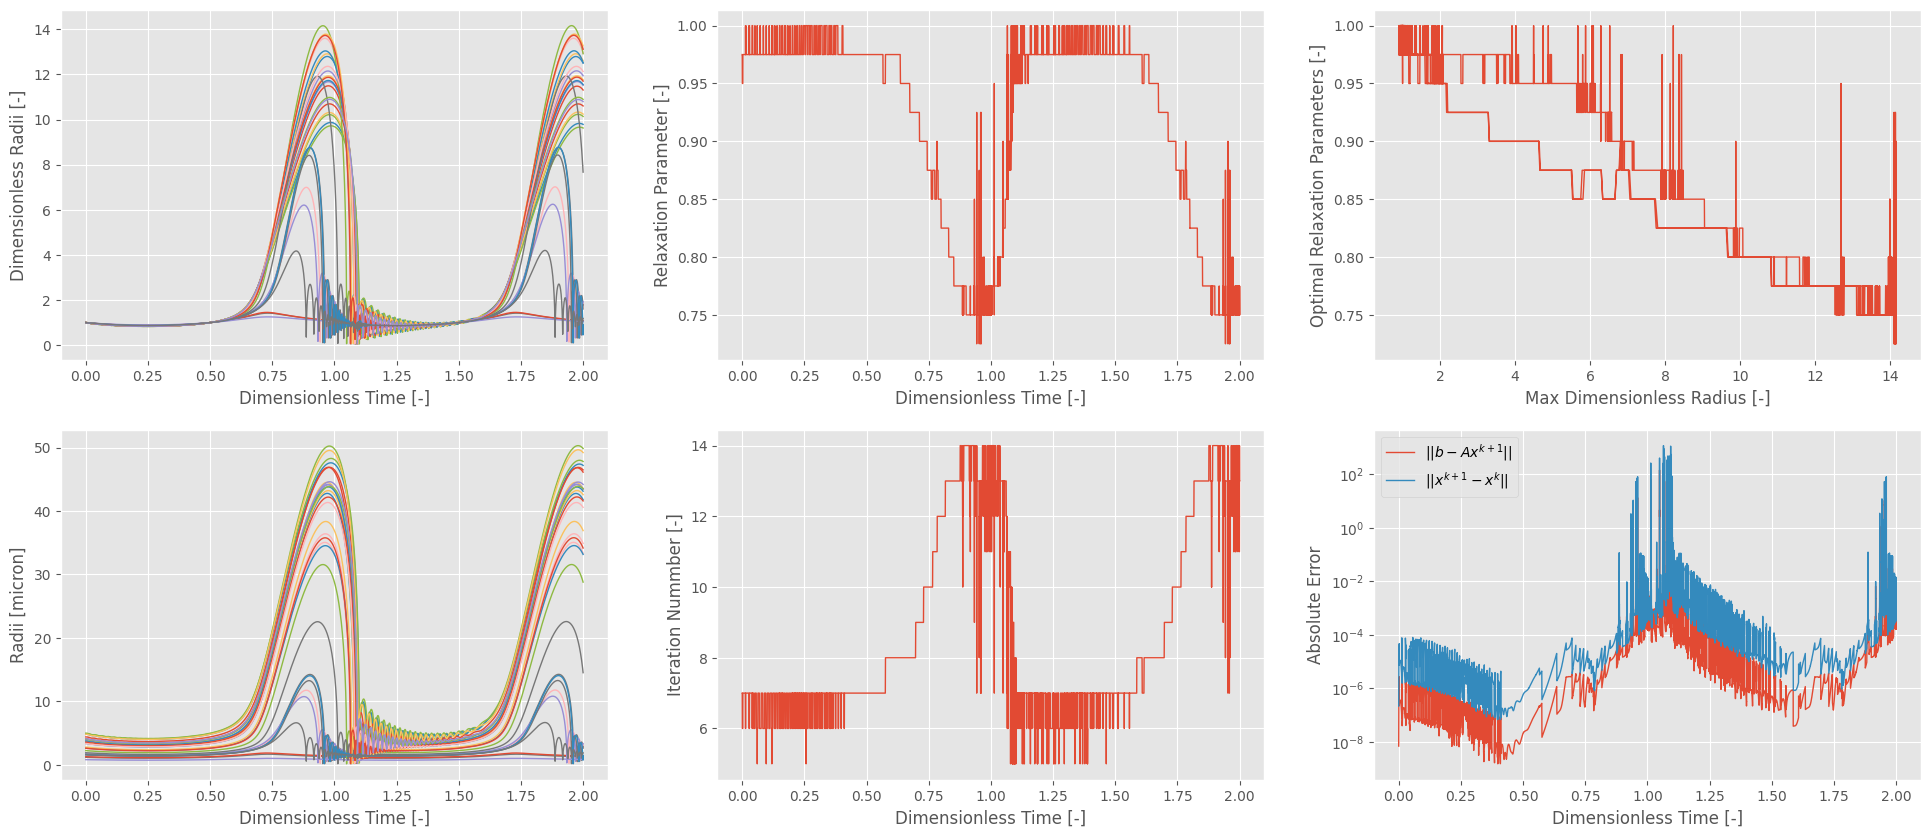

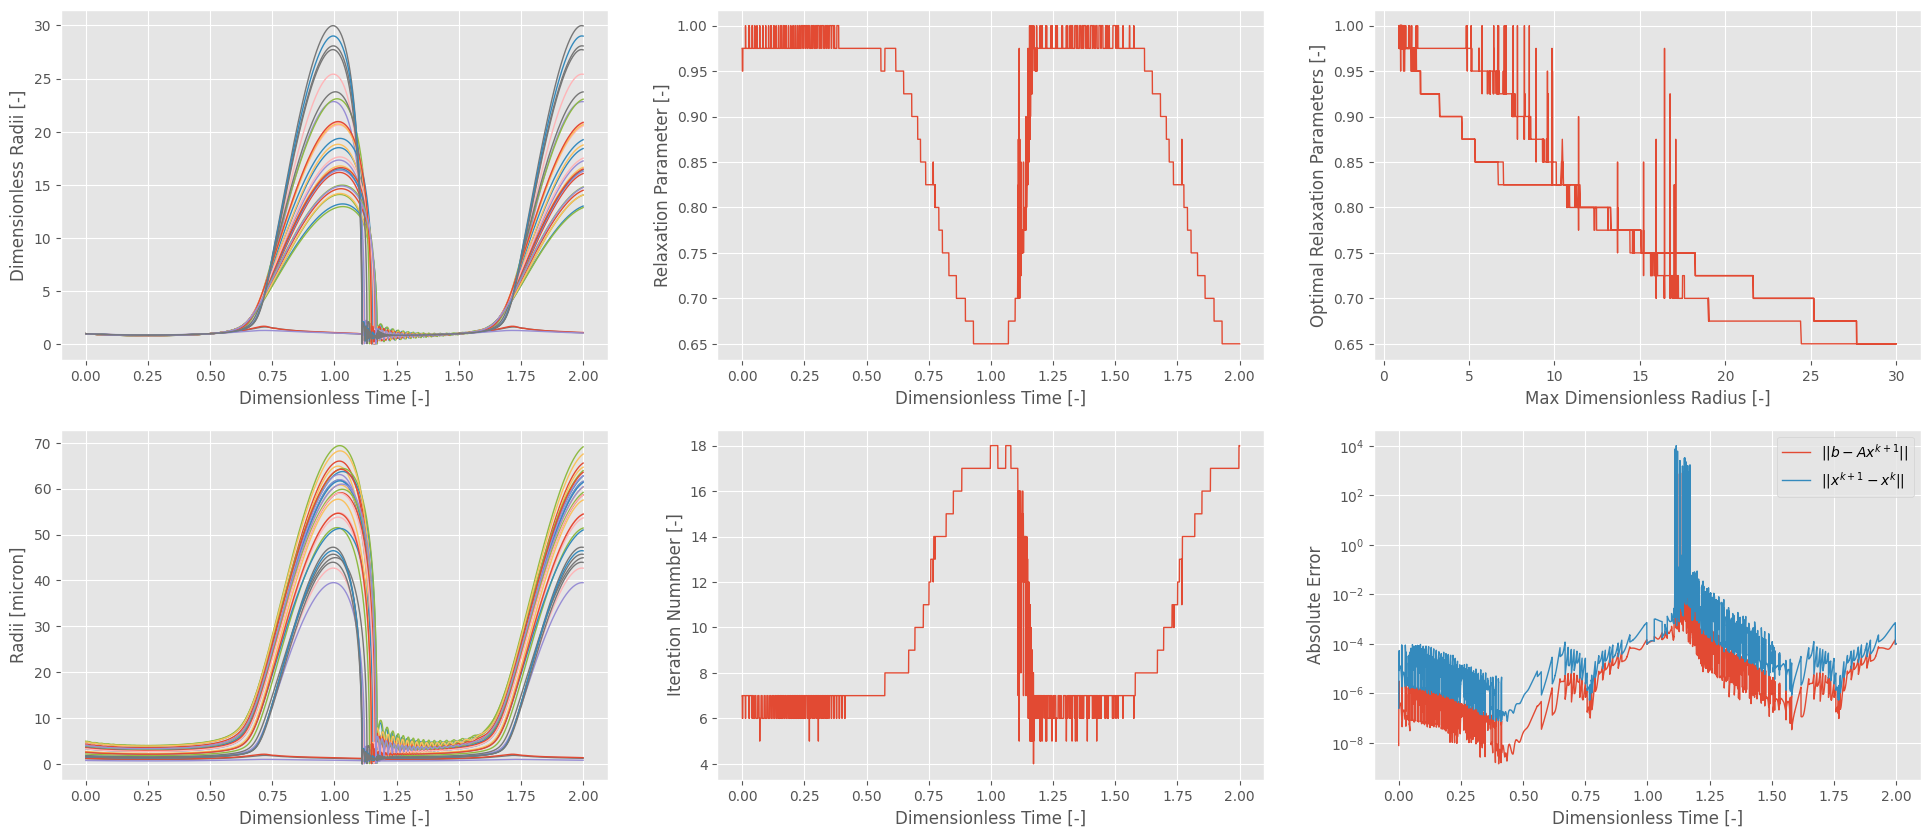

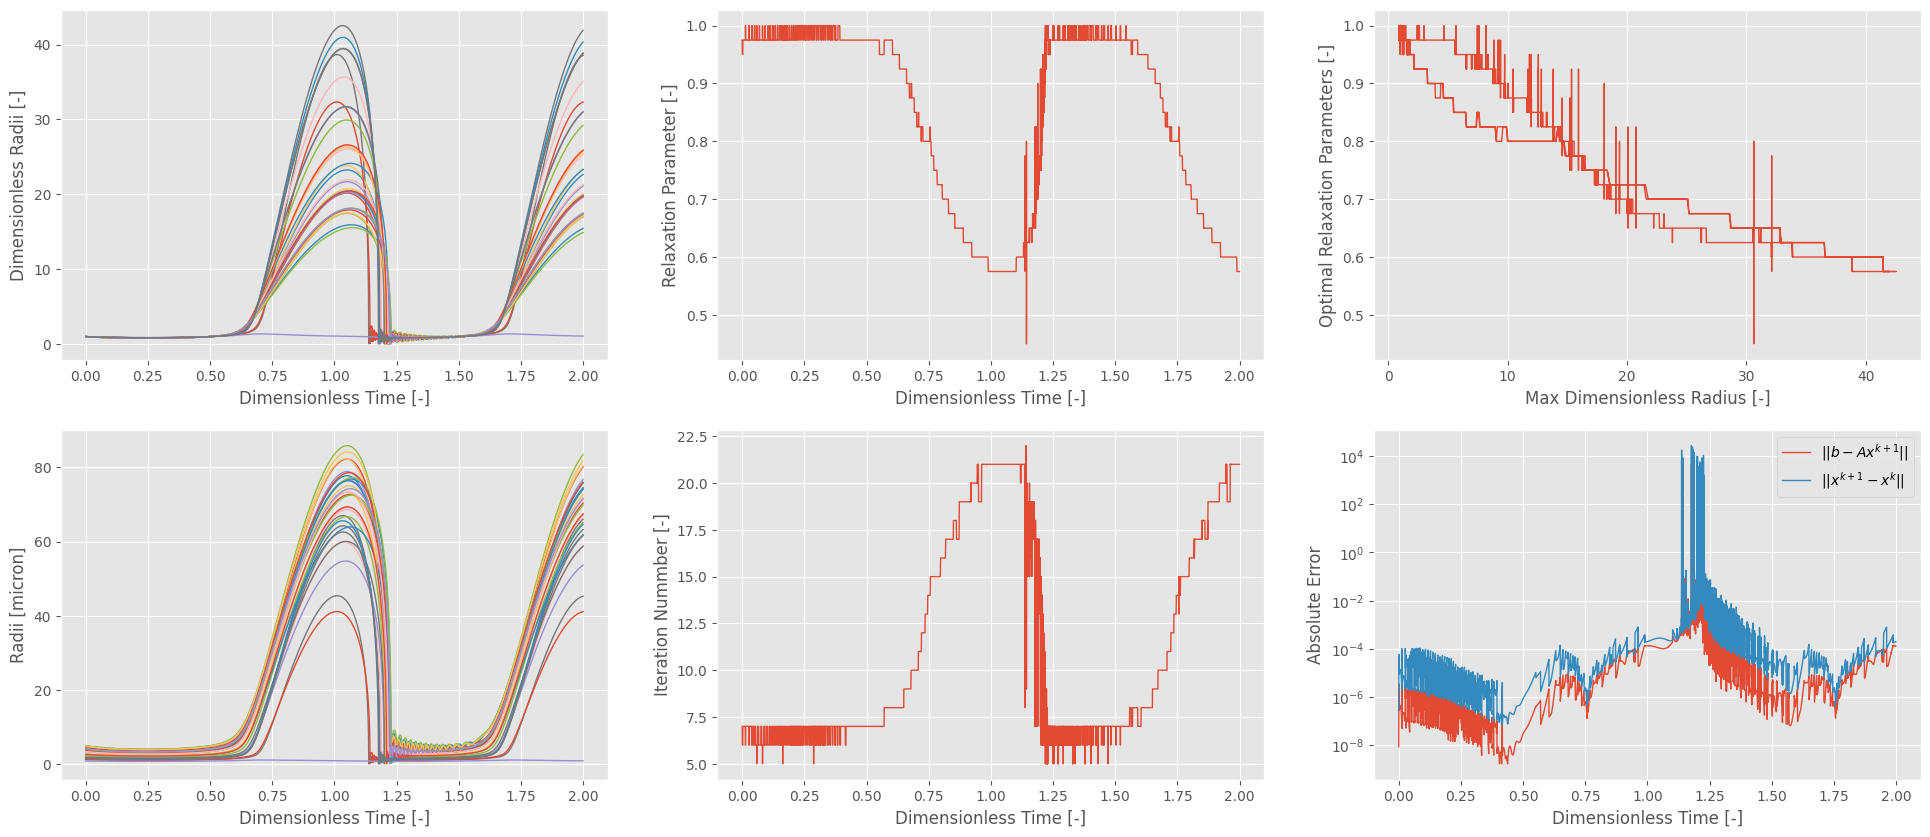

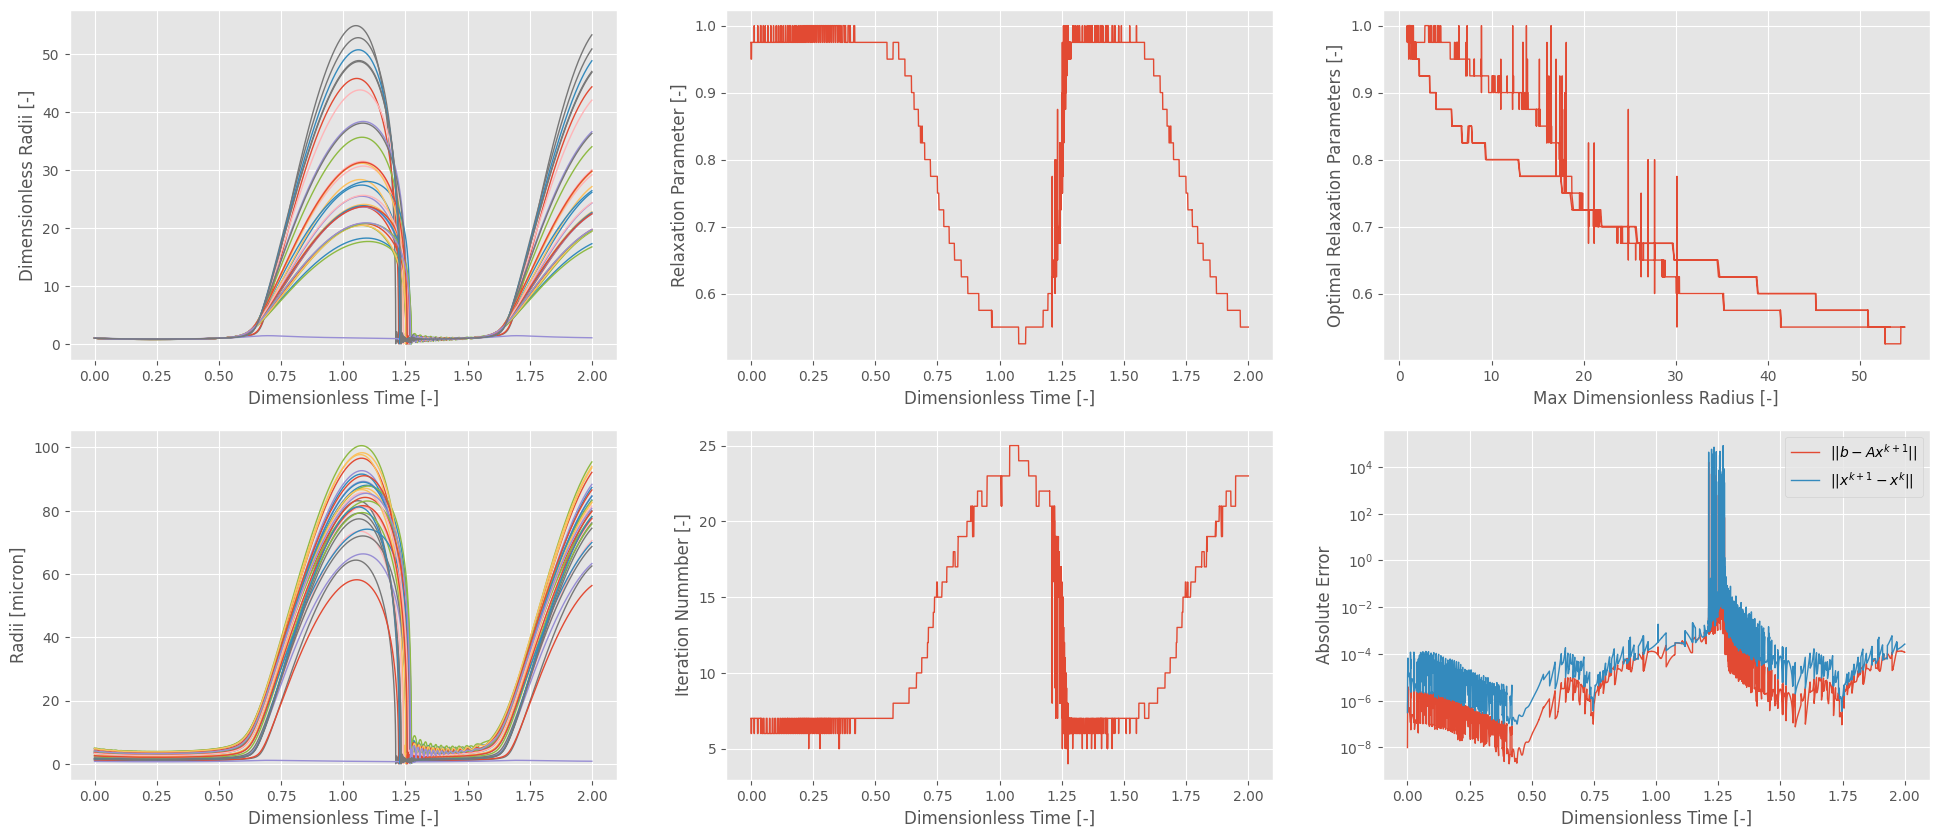

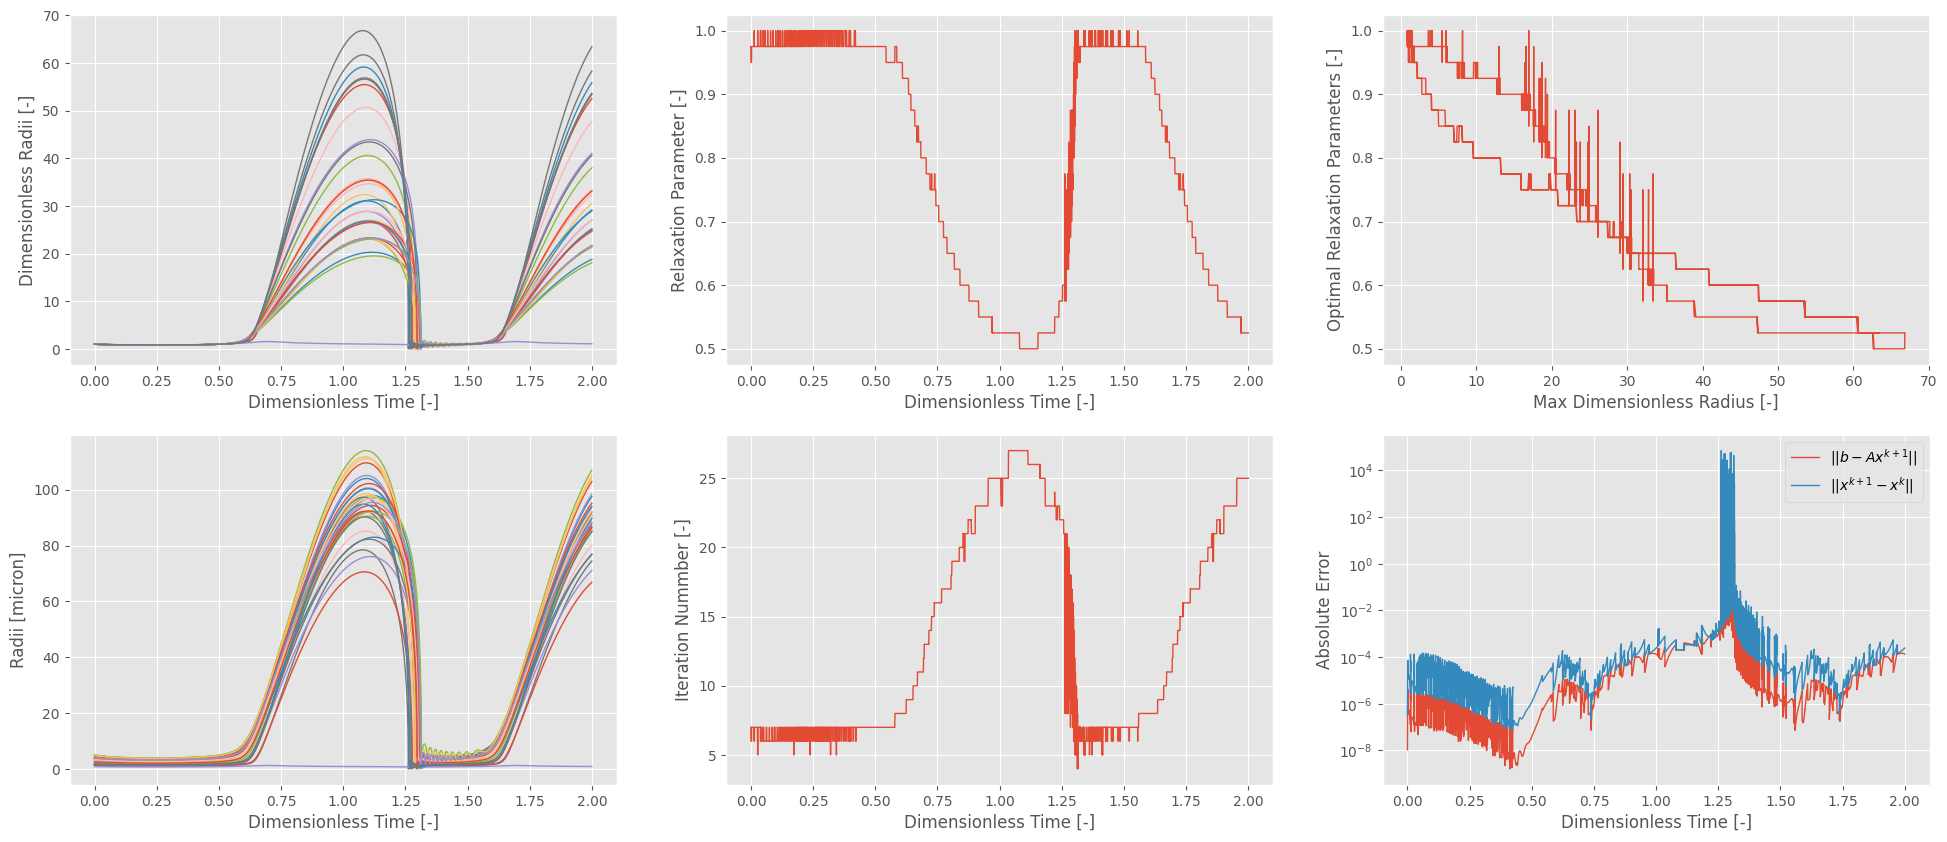

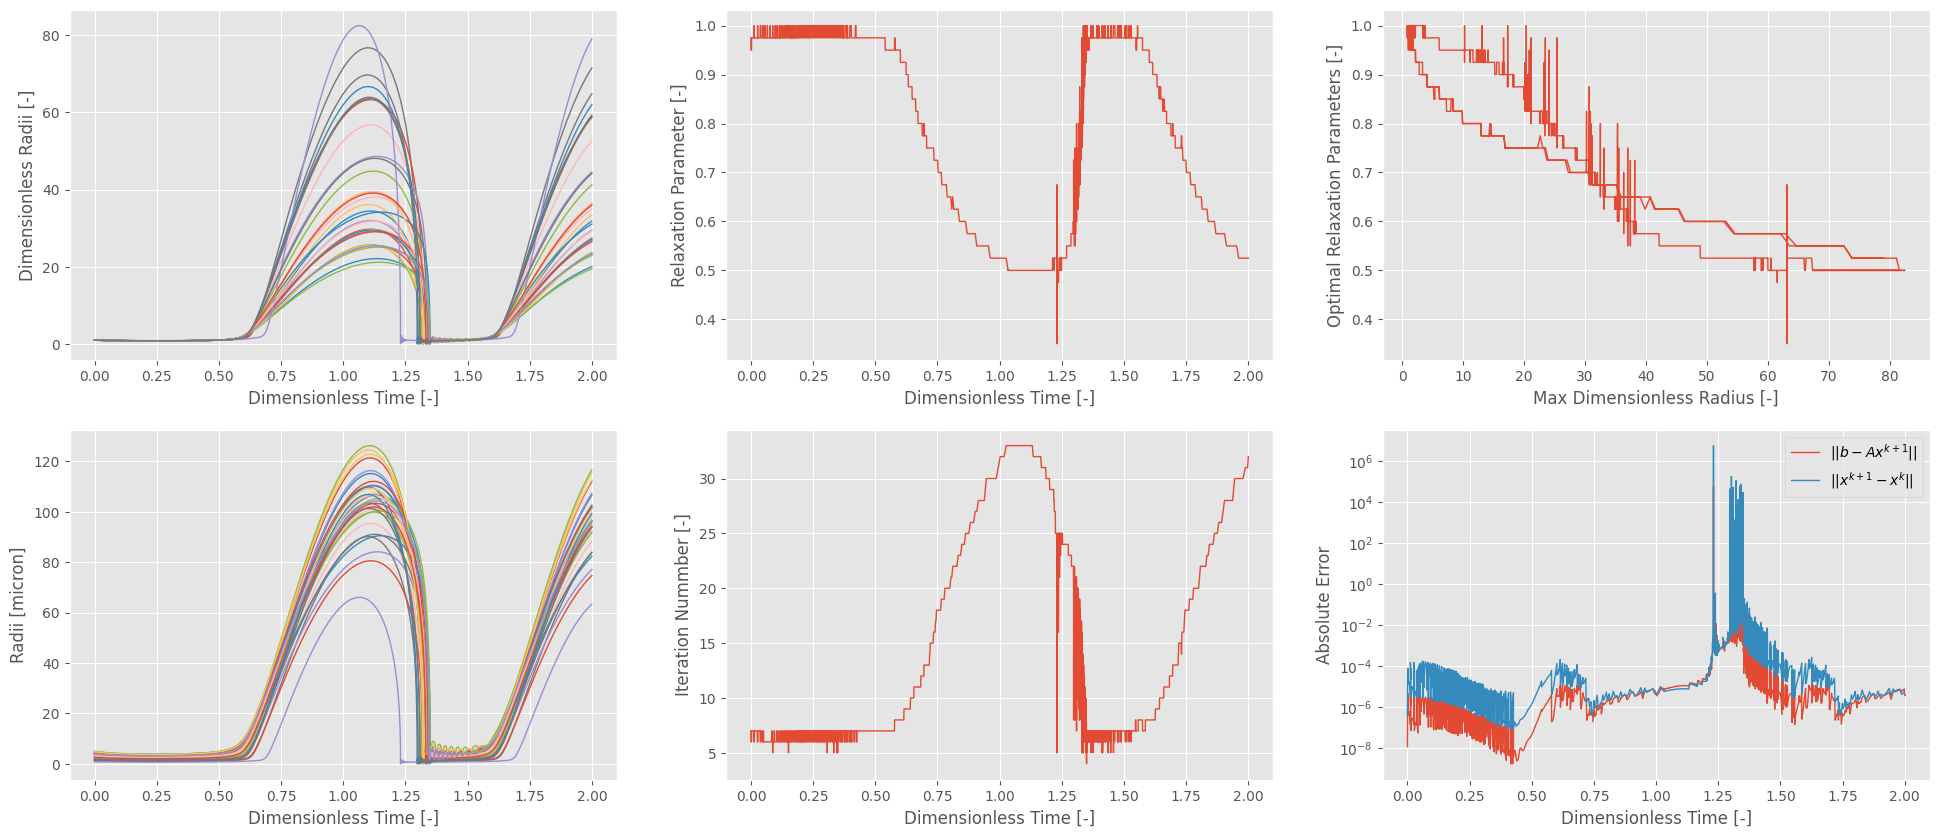

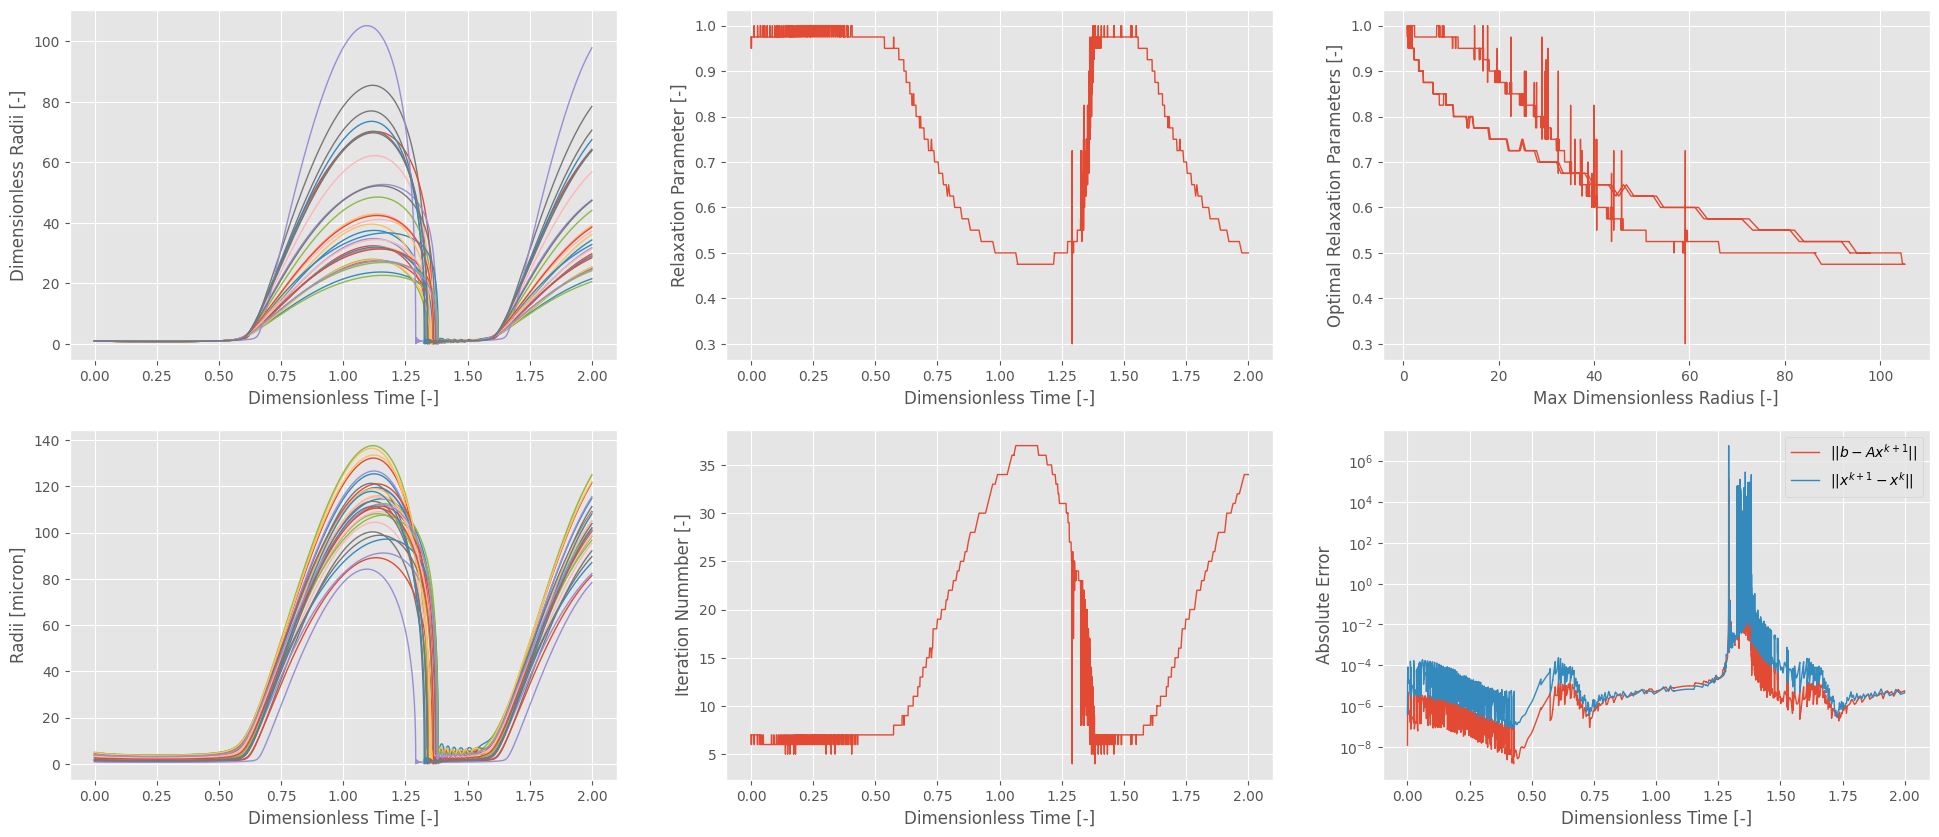

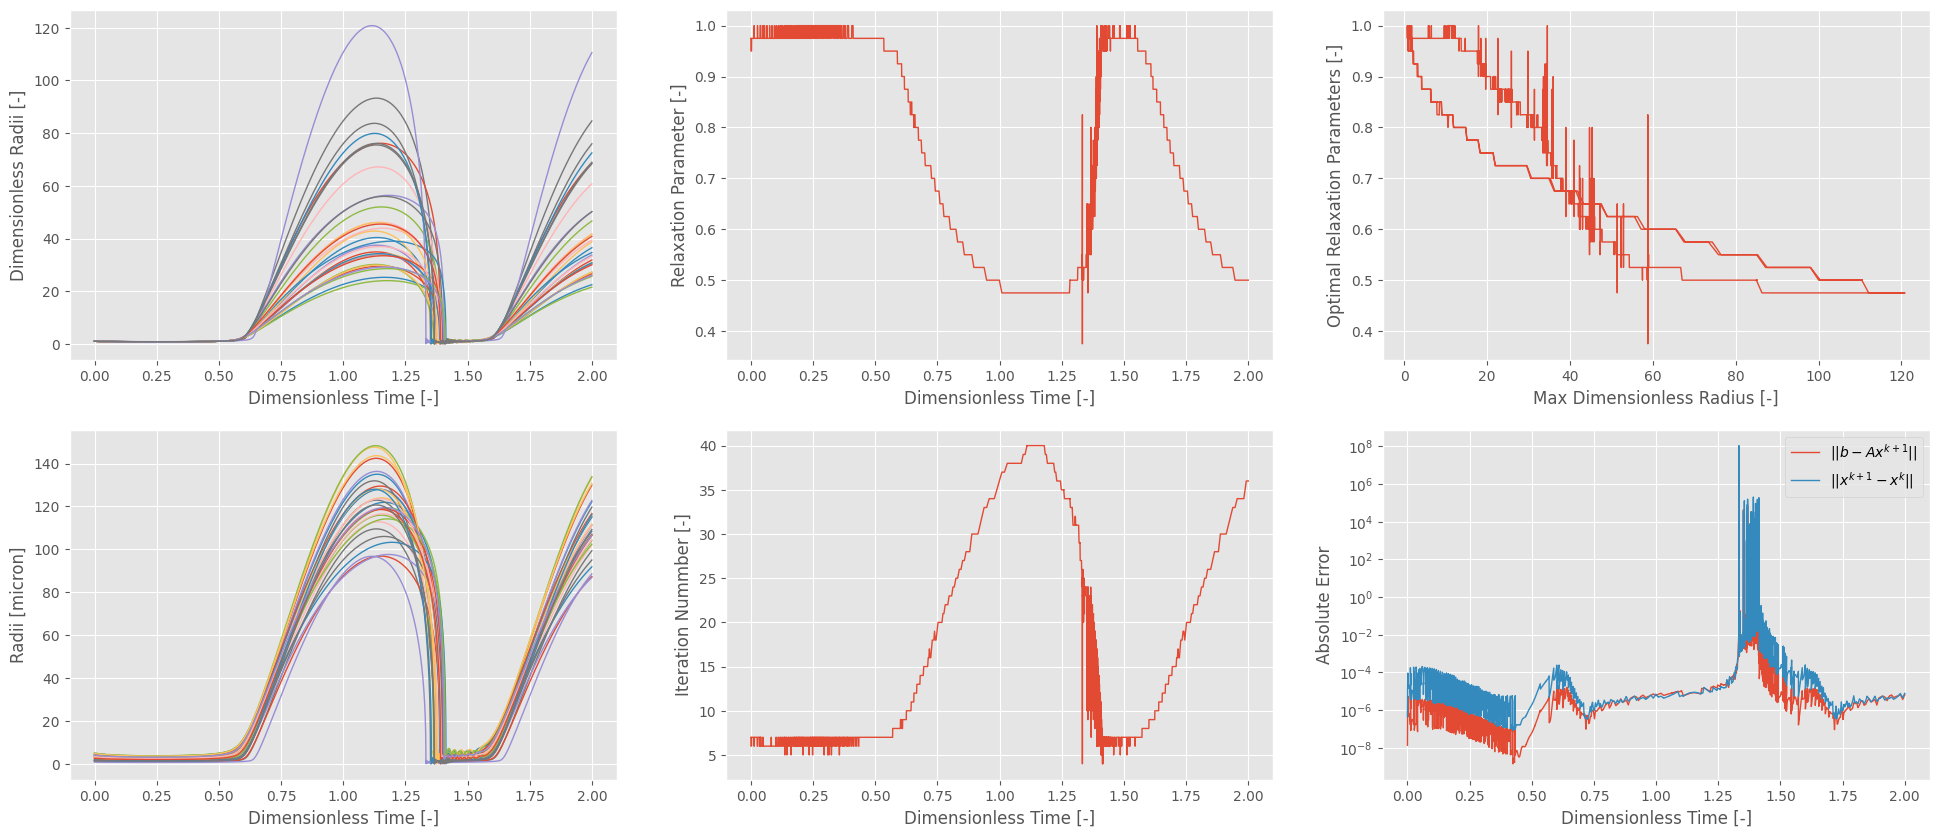

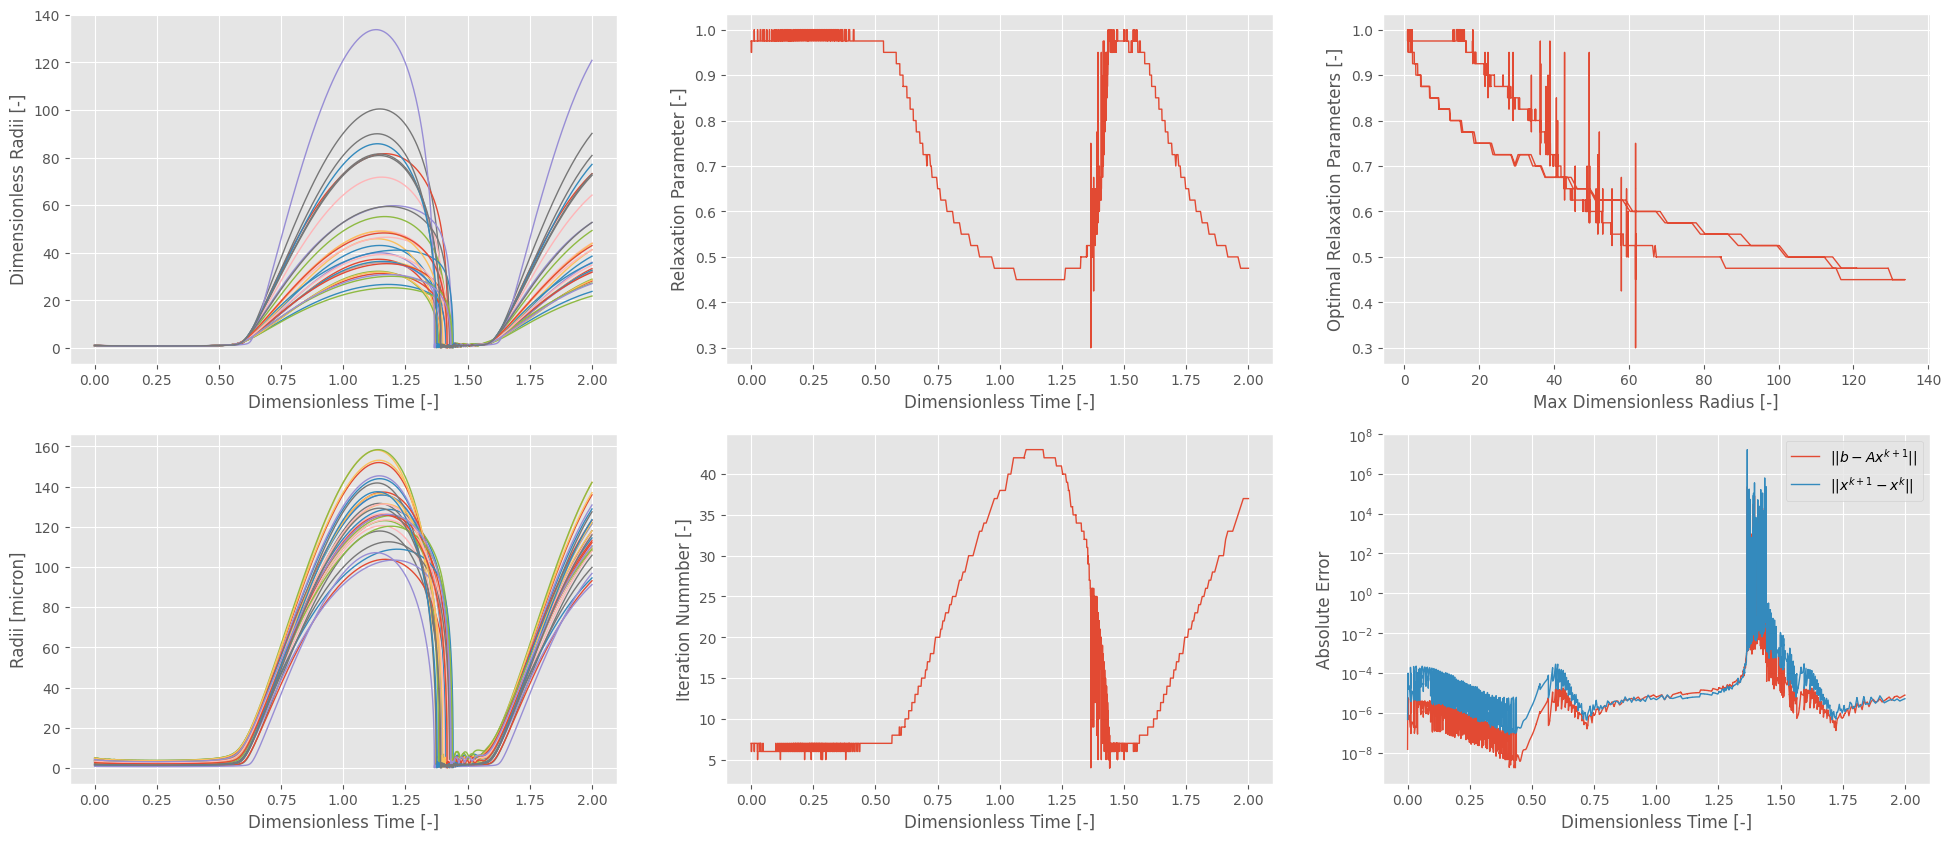

In [43]:
SEED = 21
plot_figures(32, SEED, 1.4, 25.0)
plot_figures(32, SEED, 1.6, 25.0)
plot_figures(32, SEED, 1.8, 25.0)
plot_figures(32, SEED, 2.0, 25.0)
plot_figures(32, SEED, 2.2, 25.0)
plot_figures(32, SEED, 2.4, 25.0)
plot_figures(32, SEED, 2.6, 25.0)
plot_figures(32, SEED, 2.8, 25.0)
plot_figures(32, SEED, 3.0, 25.0)

# SEED, FIX PA1

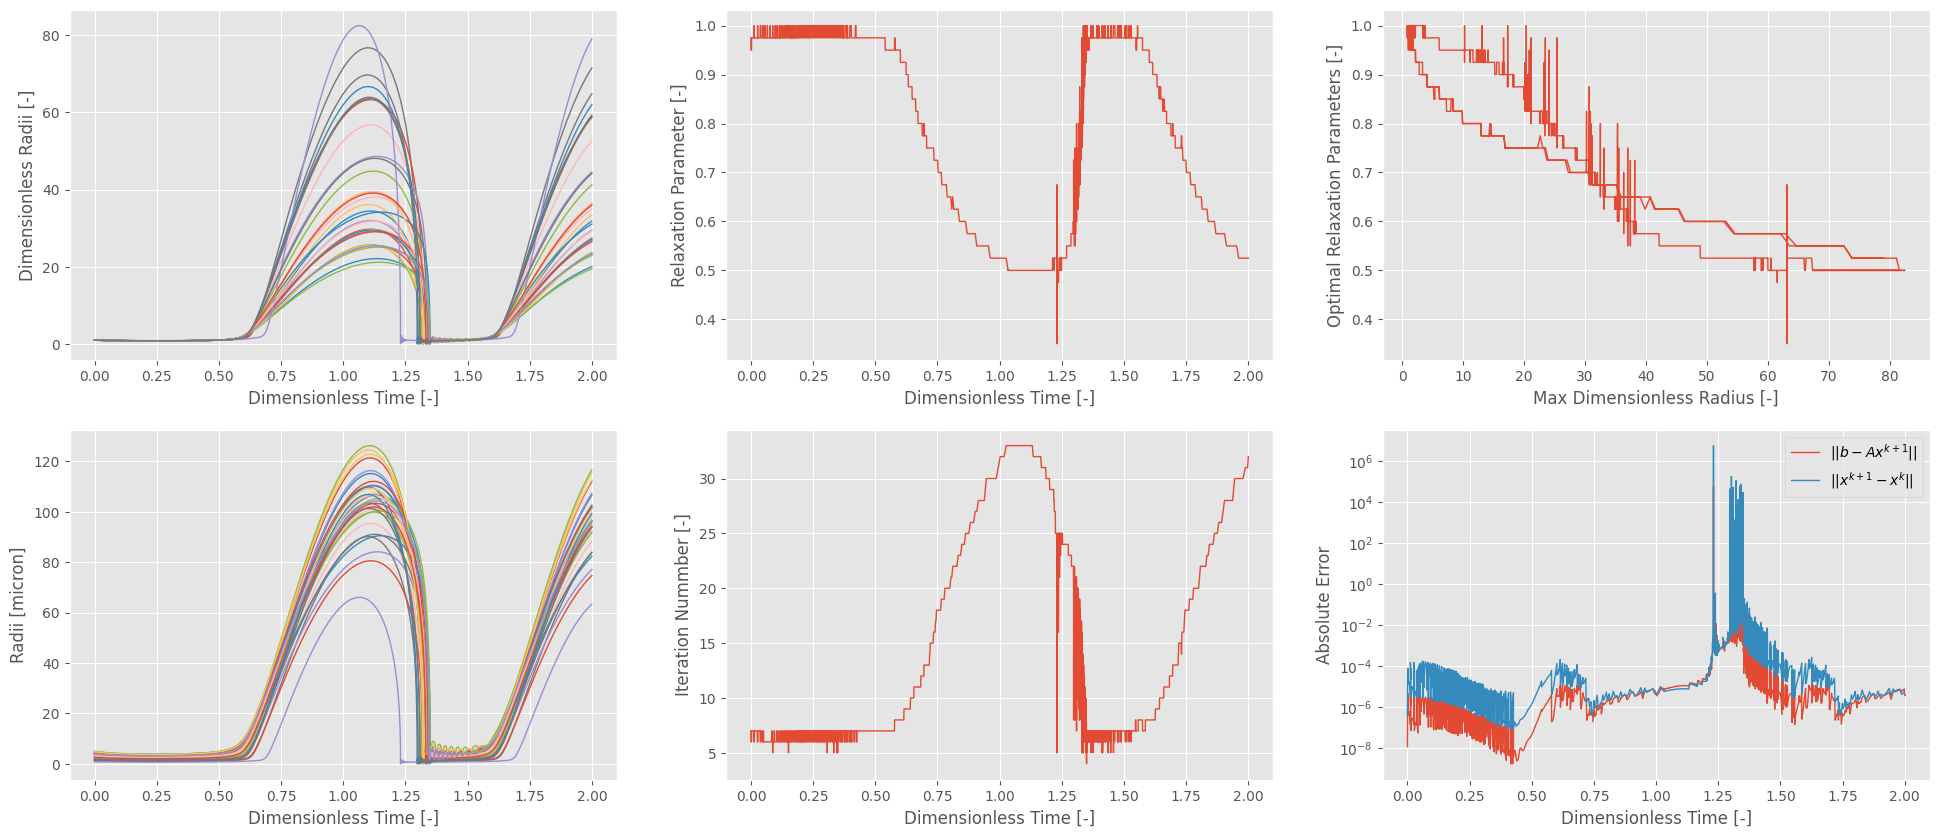

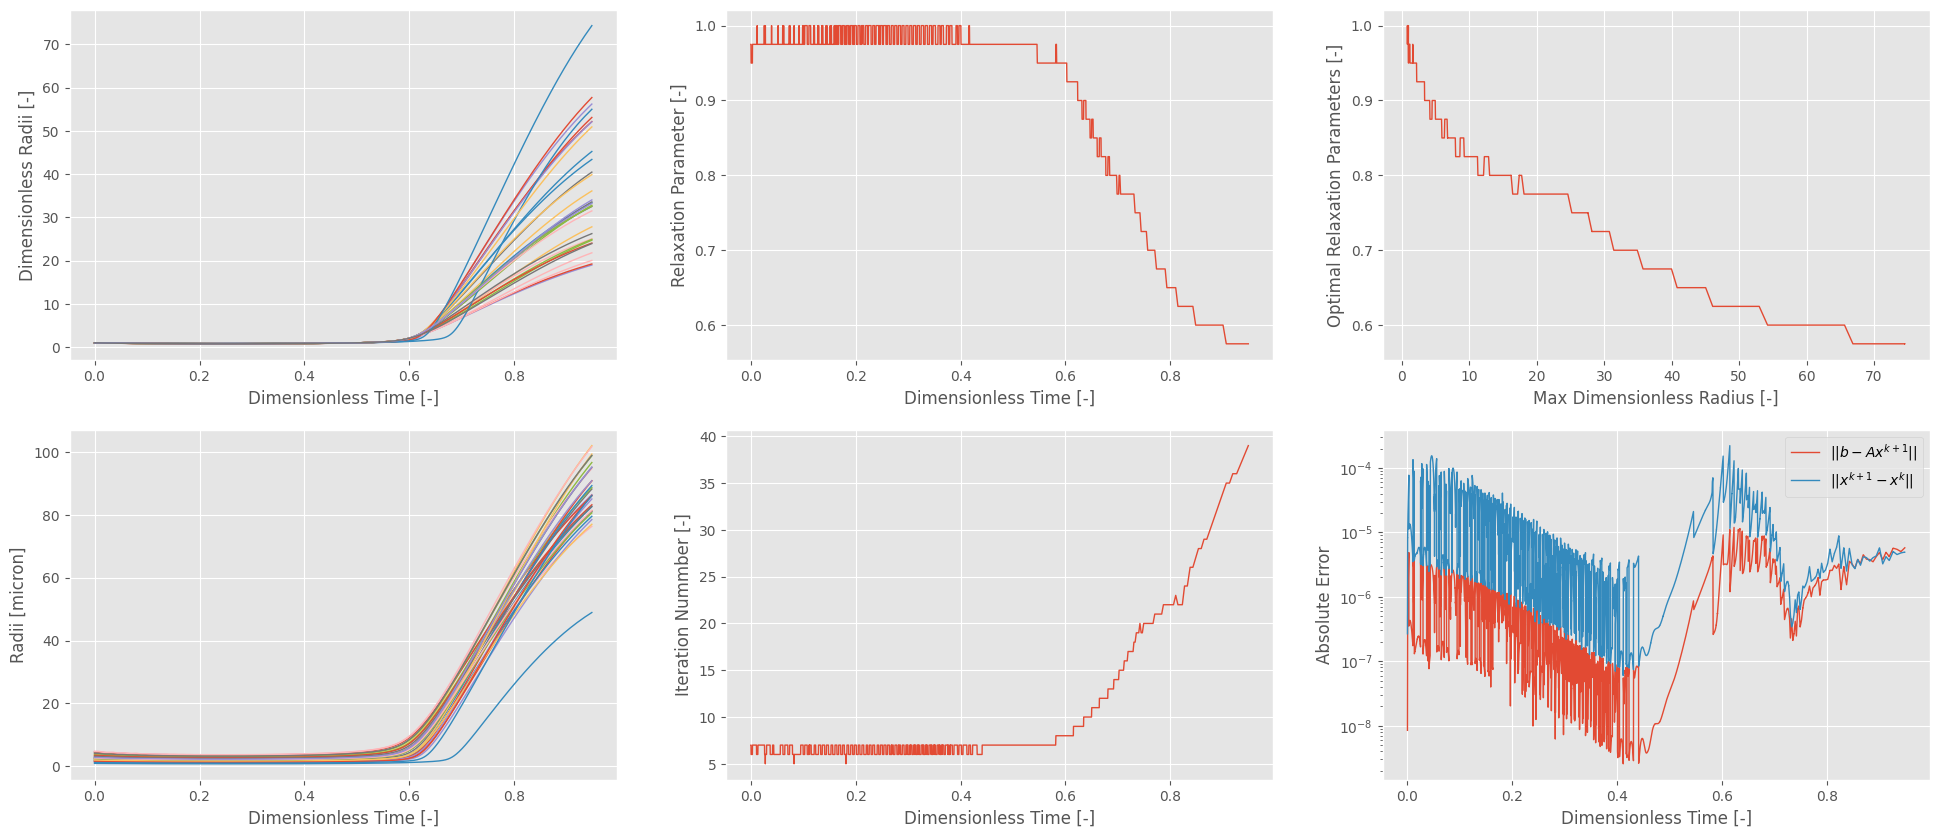

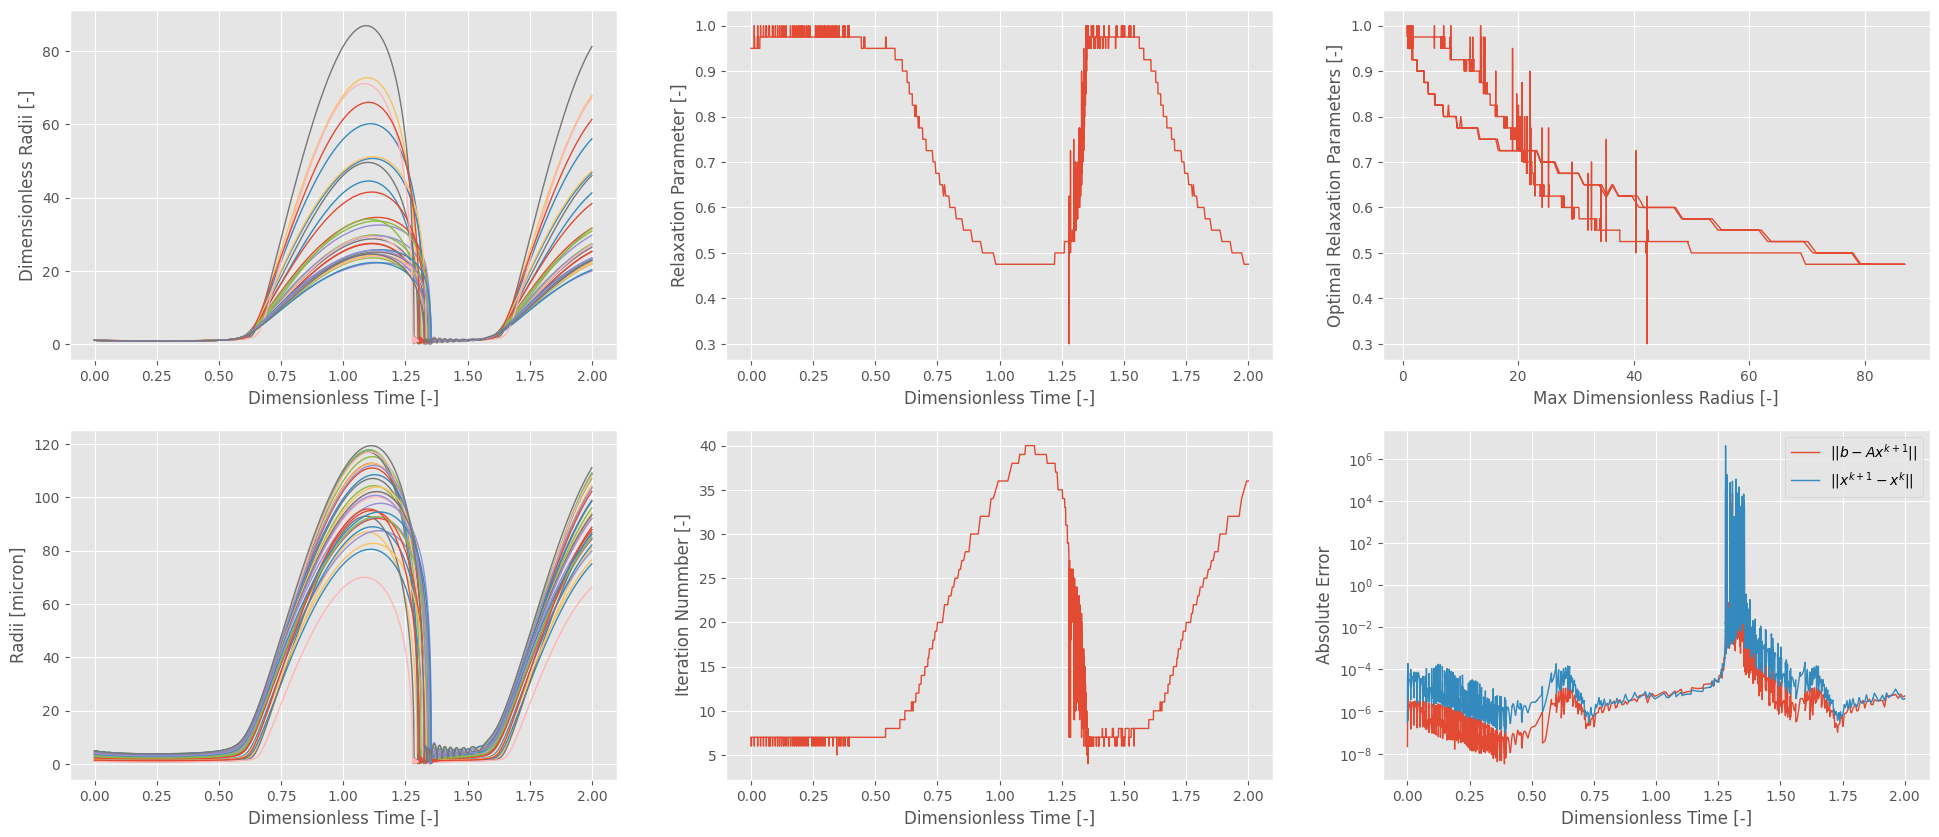

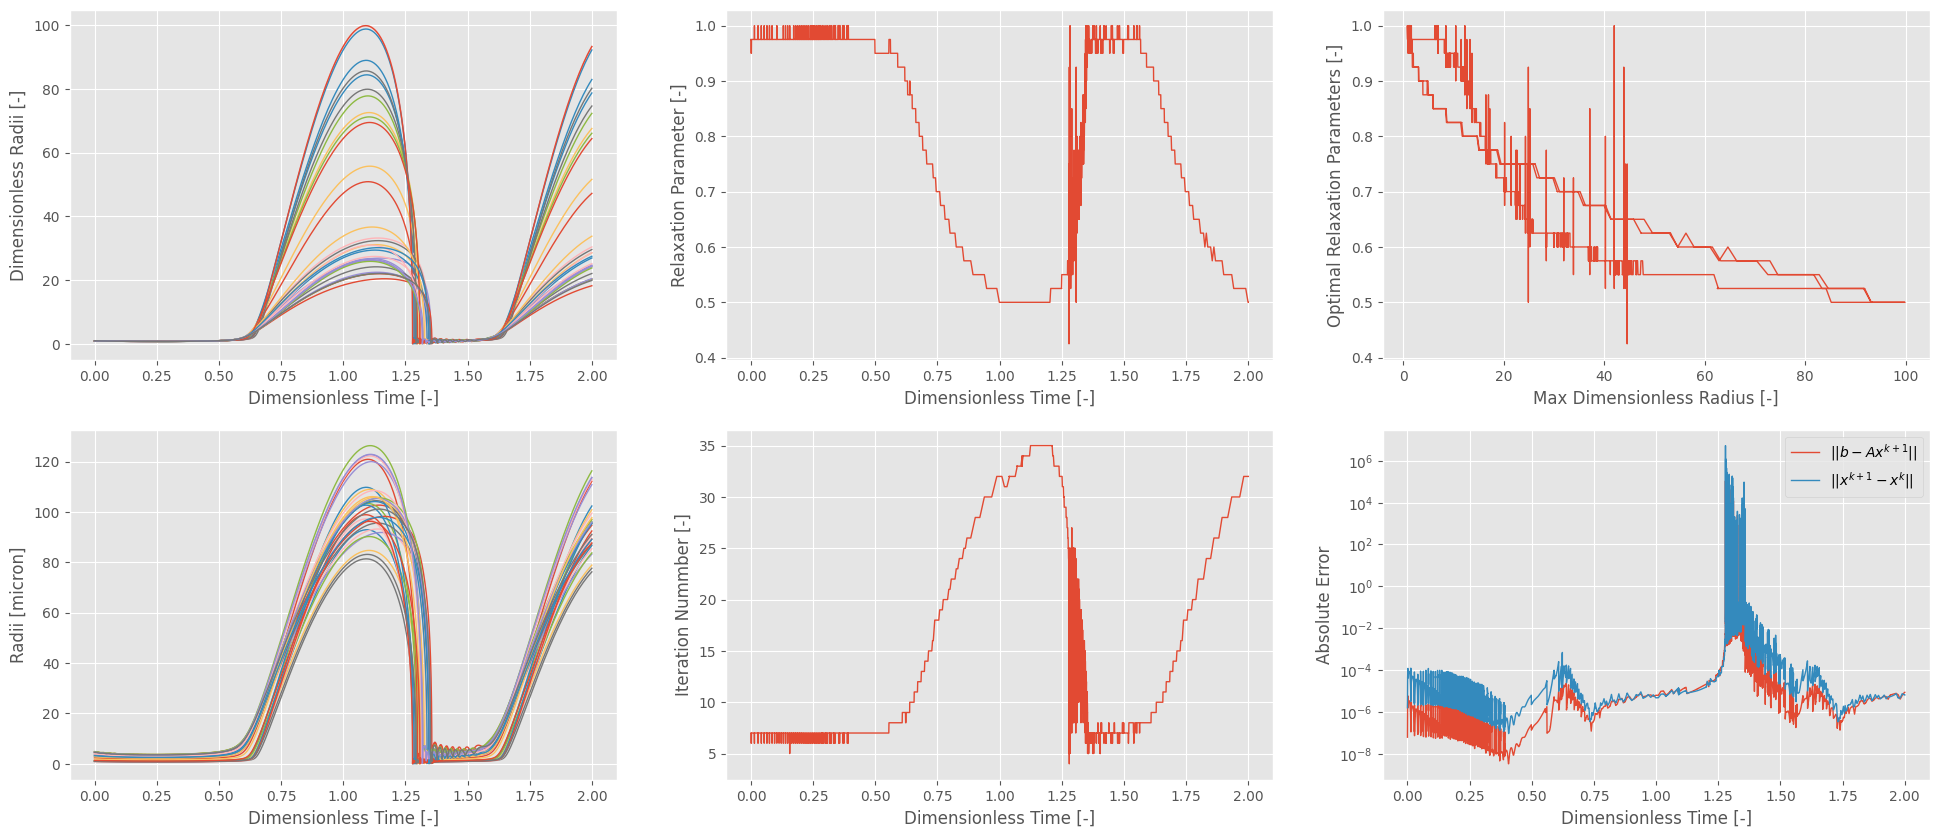

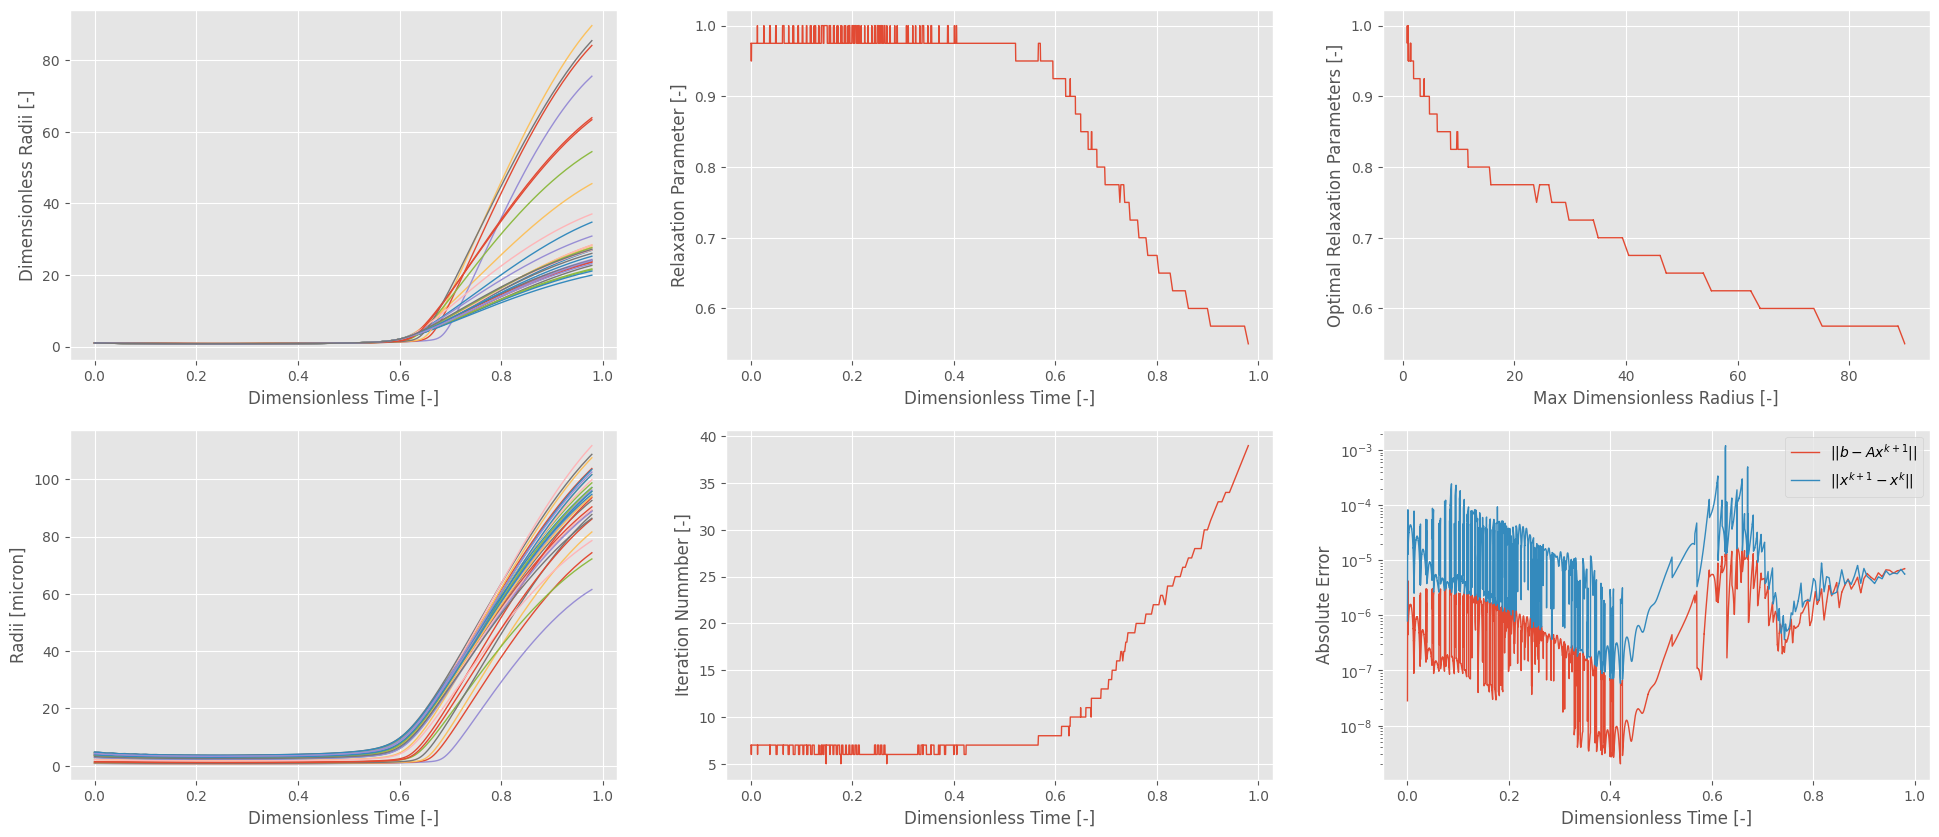

In [ ]:
SEED = 42
PA1 = 2.4
plot_figures(32, 21, PA1, 25.0)
plot_figures(32, 36, PA1, 25.0)     # Terminated
plot_figures(32, 42, PA1, 25.0)
plot_figures(32, 79, PA1, 25.0)     # Terminated
plot_figures(32, 217, PA1, 25.0)    # Terminated

## Fit Omega (Rmax)

In [ ]:
def load_metrics(seeds, P1, P2):
    rmax = []
    omega_opt = []
    s = []
    p = []
    for seed in seeds:
        for pa1 in P1:
            metrics_path = METRICS_DATA / get_cluster_config(32, seed) / get_run_name(pa1, P2)
            metrics = np.load(f"{metrics_path}_jacobi_bruteforce.npz")
            rmax.append(metrics["rmax"])
            omega_opt.append(metrics["omega"])
            s.extend([seed] * len(metrics["time"]))
            p.extend([pa1] * len(metrics["time"]))

    rmax = np.hstack(rmax)
    omega_opt = np.hstack(omega_opt)

    df = pd.DataFrame(
        {
            "seed" : s,
            "P1"   : p,
            "rmax" : rmax,
            "omega" : omega_opt
        }
    )

    return df


In [ ]:
def exp_model(r, a, b, c):
    return c * np.exp(a * r) + b

def fit_exp(df, xcol="rmax", ycol="omega", bounds=None):
    x = df[xcol].to_numpy(dtype=float)
    y = df[ycol].to_numpy(dtype=float)

    # kezdőértékek: a≈0, b≈min(y), c≈ptp(y)
    y_min, y_max = float(np.min(y)), float(np.max(y))
    c0 = max(1e-12, y_max - y_min)
    p0 = (0.0, y_min, c0)

    if bounds is None:
        # opcionálisan: c≥0 korlát
        bounds = ((-np.inf, -np.inf, 0.0), (np.inf, np.inf, np.inf))

    popt, pcov = curve_fit(exp_model, x, y, p0=p0, bounds=bounds, maxfev=20000)
    return popt, pcov

def predict_curve(popt, x_min, x_max, n=400):
    xx = np.linspace(x_min, x_max, n)
    yy = exp_model(xx, *popt)
    return xx, yy


def plot_with_fit(df, hue="seed"):
    popt, _ = fit_exp(df)
    xx, yy = predict_curve(popt, df["rmax"].min(), df["rmax"].max())

    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x="rmax", y="omega", hue=hue, s=15, edgecolor=None, alpha=0.8, palette="Dark2")
        plt.plot(xx, yy, "r-", linewidth=3, label="Fitted Curve")
        a, b, c = popt
        plt.title(f"Fit: ω = c·exp(a·max(y)) + b\n(a={a:.4f}, b={b:.4f}, c={c:.4f})")
        plt.legend(title=hue)
        plt.xlabel(r"$max_i(R_i/R_{i,0})$")
        plt.ylabel(r"$\omega_{opt}$")
        plt.tight_layout()
        plt.show()
    return popt


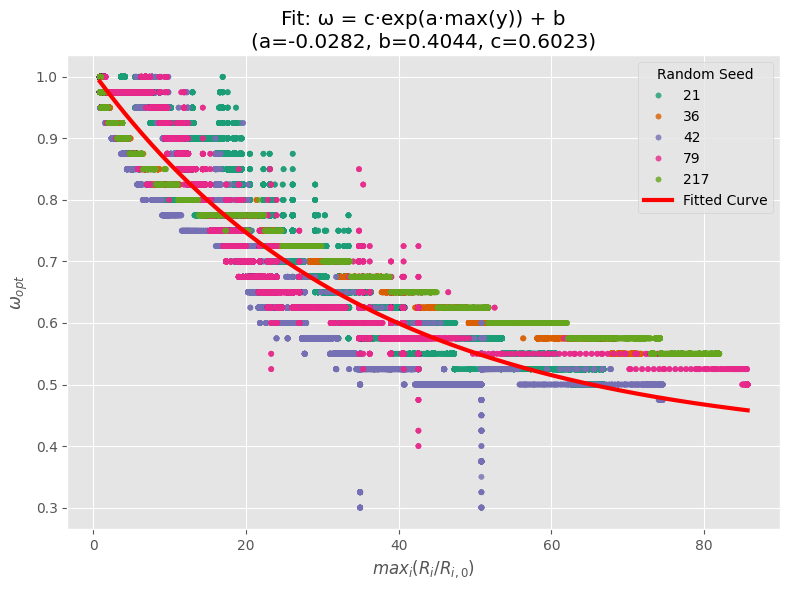

In [42]:
df = load_metrics([21, 36, 42, 79, 217], [2.2], 25.0)
popt = plot_with_fit(df, "seed")

<Figure size 800x600 with 0 Axes>

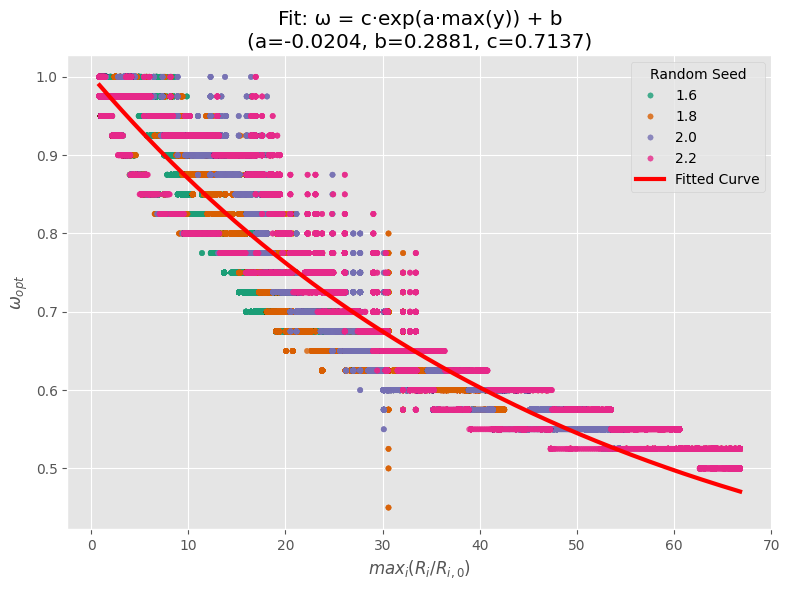

In [38]:
df = load_metrics([21], [1.6, 1.8, 2.0, 2.2], 25.0)
popt = plot_with_fit(df, "P1")

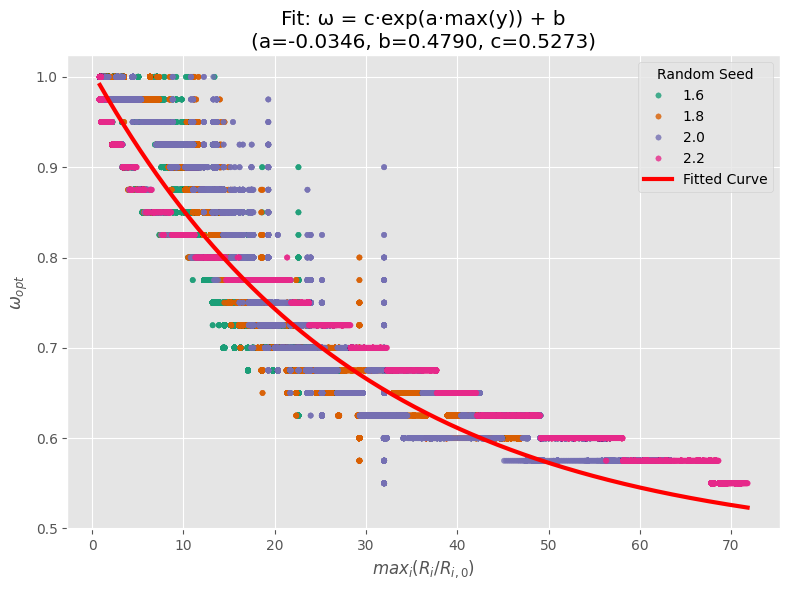

In [39]:
df = load_metrics([36], [1.6, 1.8, 2.0, 2.2], 25.0)
popt = plot_with_fit(df, "P1")

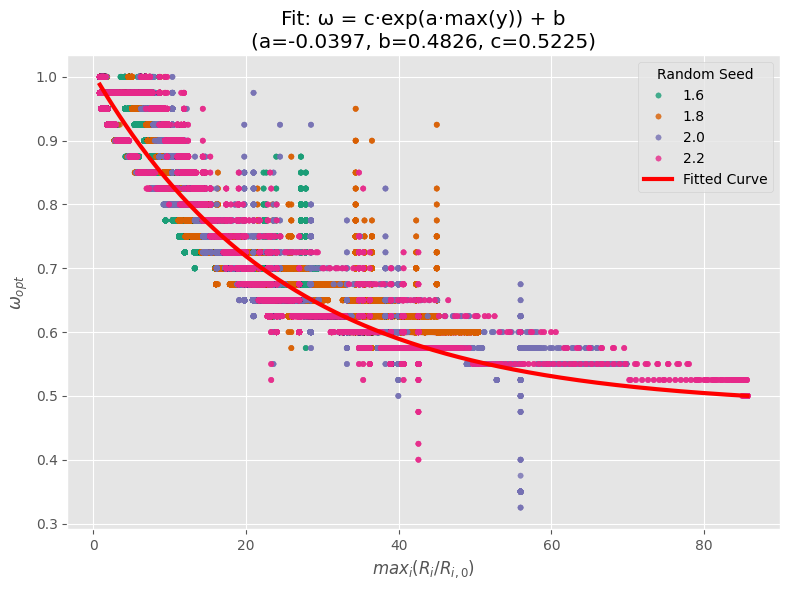

In [41]:
df = load_metrics([79], [1.6, 1.8, 2.0, 2.2], 25.0)
popt = plot_with_fit(df, "P1")

# Omega Optimization (BruteForce vs Fit)

In [48]:
def get_cluster_config(n, SEED):
    return f"N-{n:0.0f}-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-{SEED:.0f}"

def get_run_name(P1, P2):
    return f"P1-{P1:0.2f}-P2-{P2:0.2f}-P3-0.00-P4-0.00"

def plot_figures(SEED, P1, P2):
    solution_path = TIME_SERIES_DATA / get_cluster_config(32, SEED) / get_run_name(P1, P2)
    metrics_path =  METRICS_DATA / get_cluster_config(32, SEED) / get_run_name(P1, P2)
    try:
        #solution_bruteforce = np.load(f"{solution_path}_jacobi_bruteforce.npz")
        metrics_bruteforce = np.load(f"{metrics_path}_jacobi_bruteforce.npz")
        brute_force_exists = True
    except:
        brute_force_exists = False

    solution_fitted = np.load(f"{solution_path}_jacobi_fitted.npz")
    metrics_fitted = np.load(f"{metrics_path}_jacobi_fitted.npz")

    with plt.style.context('ggplot'):
        _, axes = plt.subplots(2, 3, figsize=(24, 10))

        # --- Solution ---
        axes[0,0].plot(solution_fitted["time"], solution_fitted["radii"], linewidth=1)
        axes[0,0].set_xlabel('Dimensionless Time [-]')
        axes[0,0].set_ylabel('Dimensionless Radii [-]')

        axes[1,0].plot(solution_fitted["time"], solution_fitted["radii_micron"], linewidth=1)
        axes[1,0].set_xlabel('Dimensionless Time [-]')
        axes[1,0].set_ylabel('Radii [micron]')


        # --- Metrics ---
        # Opt Omega
        axes[0,1].plot(metrics_fitted["time"], metrics_fitted["omega"], linewidth=1, label="Fitted")
        axes[0,1].set_xlabel('Dimensionless Time [-]')
        axes[0,1].set_ylabel('Relaxation Parameter [-]')

        # Iteration Number
        axes[1,1].plot(metrics_fitted["time"], metrics_fitted["iters"], linewidth=1, label="Fitted")
        axes[1,1].set_xlabel('Dimensionless Time [-]')
        axes[1,1].set_ylabel('Iteration Nummber [-]')

        # Omega vs Rmax
        axes[0,2].plot(metrics_fitted["rmax"], metrics_fitted["omega"], linewidth=1, label="Fitted")
        axes[0,2].set_xlabel('Max Dimensionless Radius [-]')
        axes[0,2].set_ylabel('Optimal Relaxation Parameters [-]')

        # Residuum
        axes[1,2].plot(metrics_fitted["time"], metrics_fitted["linalg_error"], linewidth=1, label=r"$||b-Ax^{k+1}||$ (Fitted)")
        axes[1,2].plot(metrics_fitted["time"], metrics_fitted["last_stepsize"], linewidth=1, label=r"$||x^{k+1}-x^{k}||$ (Fitted)")
        axes[1,2].set_xlabel('Dimensionless Time [-]')
        axes[1,2].set_ylabel('Absolute Error')
        axes[1,2].legend()
        axes[1,2].set_yscale('log')

    if brute_force_exists:
        axes[0,1].plot(metrics_bruteforce["time"], metrics_bruteforce["omega"], linewidth=1, label="BruteForce")
        axes[1,1].plot(metrics_bruteforce["time"], metrics_bruteforce["iters"], linewidth=1, label="BruteForce")
        axes[0,2].plot(metrics_bruteforce["rmax"], metrics_bruteforce["omega"], linewidth=1, label="BruteForce")
        axes[1,2].plot(metrics_bruteforce["time"], metrics_bruteforce["linalg_error"], linewidth=1, label=r"$||b-Ax^{k+1}||$ (BruteForce)")
        axes[1,2].plot(metrics_bruteforce["time"], metrics_bruteforce["last_stepsize"], linewidth=1, label=r"$||x^{k+1}-x^{k}||$ (BruteForce)")
        axes[0,1].legend()
        axes[1,1].legend()
        axes[0,2].legend()
        axes[1,2].legend()

    plt.show()


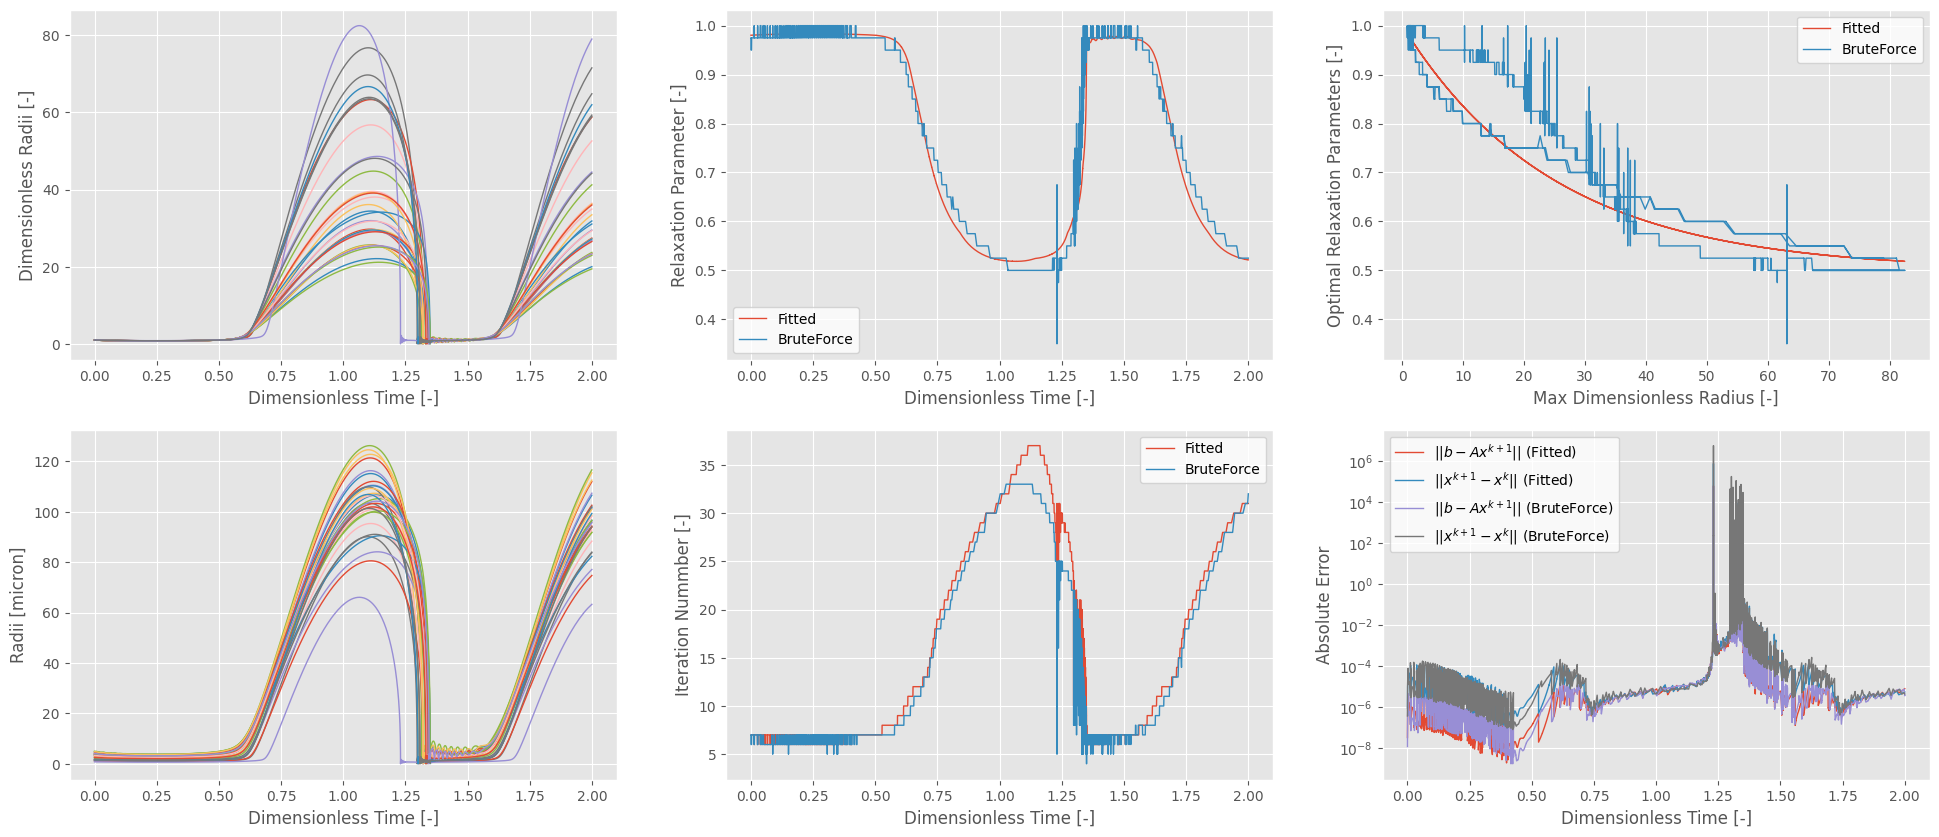

In [56]:
SEED = 21
PA1 = 2.4
plot_figures(SEED, PA1, 25.0)

# Comparison Of Iterative Methods

In [85]:
def get_cluster_config(n, SEED):
    return f"N-{n:0.0f}-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-{SEED:.0f}"

def get_run_name(P1, P2):
    return f"P1-{P1:0.2f}-P2-{P2:0.2f}-P3-0.00-P4-0.00"

def plot_figures(SEED, P1, P2):
    solution_path = TIME_SERIES_DATA / get_cluster_config(32, SEED) / get_run_name(P1, P2)
    metrics_path = METRICS_DATA / get_cluster_config(32, SEED) / get_run_name(P1, P2)

    solution_bicg = np.load(f"{solution_path}_bicg.npz")
    metrics_bicg = np.load(f"{metrics_path}_bicg.npz")
    metrics_bicgstab = np.load(f"{metrics_path}_bicgstab.npz")
    metrics_fitted = np.load(f"{metrics_path}_jacobi_fitted.npz")
    metrics_jacobi_bruteforce = np.load(f"{metrics_path}_jacobi_bruteforce.npz")

    print("Number of Function Evaluations")
    print("BiCG", len(metrics_bicg["time"]))
    print("BiCGSTAB", len(metrics_bicgstab["time"]))
    print("JACOBI FITTED", len(metrics_fitted["time"]))
    print("JACOBI BRUTEFORCE", len(metrics_jacobi_bruteforce["time"]))

    print("Total Number of Iterations")
    print("BiCG", sum(metrics_bicg["iters"]))
    print("BiCGSTAB", sum(metrics_bicgstab["iters"]))
    print("JACOBI FITTED", sum(metrics_fitted["iters"]))
    print("JACOBI BRUTEFORCE", sum(metrics_jacobi_bruteforce["iters"]))


    with plt.style.context('ggplot'):
        _, axes = plt.subplots(2, 2, figsize=(16, 10))

        # --- Solution ---
        axes[0,0].plot(solution_bicg["time"], solution_bicg["radii"], linewidth=1)
        axes[0,0].set_xlabel('Dimensionless Time [-]')
        axes[0,0].set_ylabel('Dimensionless Radii [-]')

        axes[1,0].plot(solution_bicg["time"], solution_bicg["radii_micron"], linewidth=1)
        axes[1,0].set_xlabel('Dimensionless Time [-]')
        axes[1,0].set_ylabel('Radii [micron]')

        # Iteration Number
        axes[0,1].plot(metrics_jacobi_bruteforce["time"], metrics_jacobi_bruteforce["iters"], linewidth=1, label="BruteForce")
        axes[0,1].plot(metrics_fitted["time"], metrics_fitted["iters"], linewidth=1, label="Fitted")
        axes[0,1].plot(metrics_bicg["time"], metrics_bicg["iters"], linewidth=1, label="BiCG")
        axes[0,1].plot(metrics_bicgstab["time"], metrics_bicgstab["iters"], linewidth=1, label="BiCGSTAB")
        axes[0,1].set_xlabel('Dimensionless Time [-]')
        axes[0,1].set_ylabel('Iteration Nummber [-]')
        axes[0,1].legend()

        # Residuum
        axes[1,1].plot(metrics_jacobi_bruteforce["time"], metrics_jacobi_bruteforce["linalg_error"], linewidth=1, label=r"$||b-Ax^{k+1}||$ (BruteForce)")
        axes[1,1].plot(metrics_jacobi_bruteforce["time"], metrics_jacobi_bruteforce["last_stepsize"], linewidth=1, label=r"$||x^{k+1}-x^{k}||$ (BruteForce)")
        axes[1,1].plot(metrics_fitted["time"], metrics_fitted["linalg_error"], linewidth=1, label=r"$||b-Ax^{k+1}||$ (Fitted)")
        axes[1,1].plot(metrics_fitted["time"], metrics_fitted["last_stepsize"], linewidth=1, label=r"$||x^{k+1}-x^{k}||$ (Fitted)")
        axes[1,1].plot(metrics_bicg["time"], metrics_bicg["linalg_error"], linewidth=1, label=r"$||b-Ax^{k+1}||$ (BiCG)")
        axes[1,1].plot(metrics_bicg["time"], metrics_bicg["last_stepsize"], linewidth=1, label=r"$||x^{k+1}-x^{k}||$ (BiCG)")
        axes[1,1].plot(metrics_bicgstab["time"], metrics_bicgstab["linalg_error"], linewidth=1, label=r"$||b-Ax^{k+1}||$ (BiCGSTAB)")
        axes[1,1].plot(metrics_bicgstab["time"], metrics_bicgstab["last_stepsize"], linewidth=1, label=r"$||x^{k+1}-x^{k}||$ (BiCGSTAB)")
        axes[1,1].set_xlabel('Dimensionless Time [-]')
        axes[1,1].set_ylabel('Absolute Error')
        axes[1,1].legend()
        axes[1,1].set_yscale('log')


    plt.show()

Number of Function Evaluations
BiCG 215832
BiCGSTAB 307786
JACOBI FITTED 225955
JACOBI BRUTEFORCE 217820
Total Number of Iterations
BiCG 1273011
BiCGSTAB 1295766
JACOBI FITTED 3065079
JACOBI BRUTEFORCE 2471809


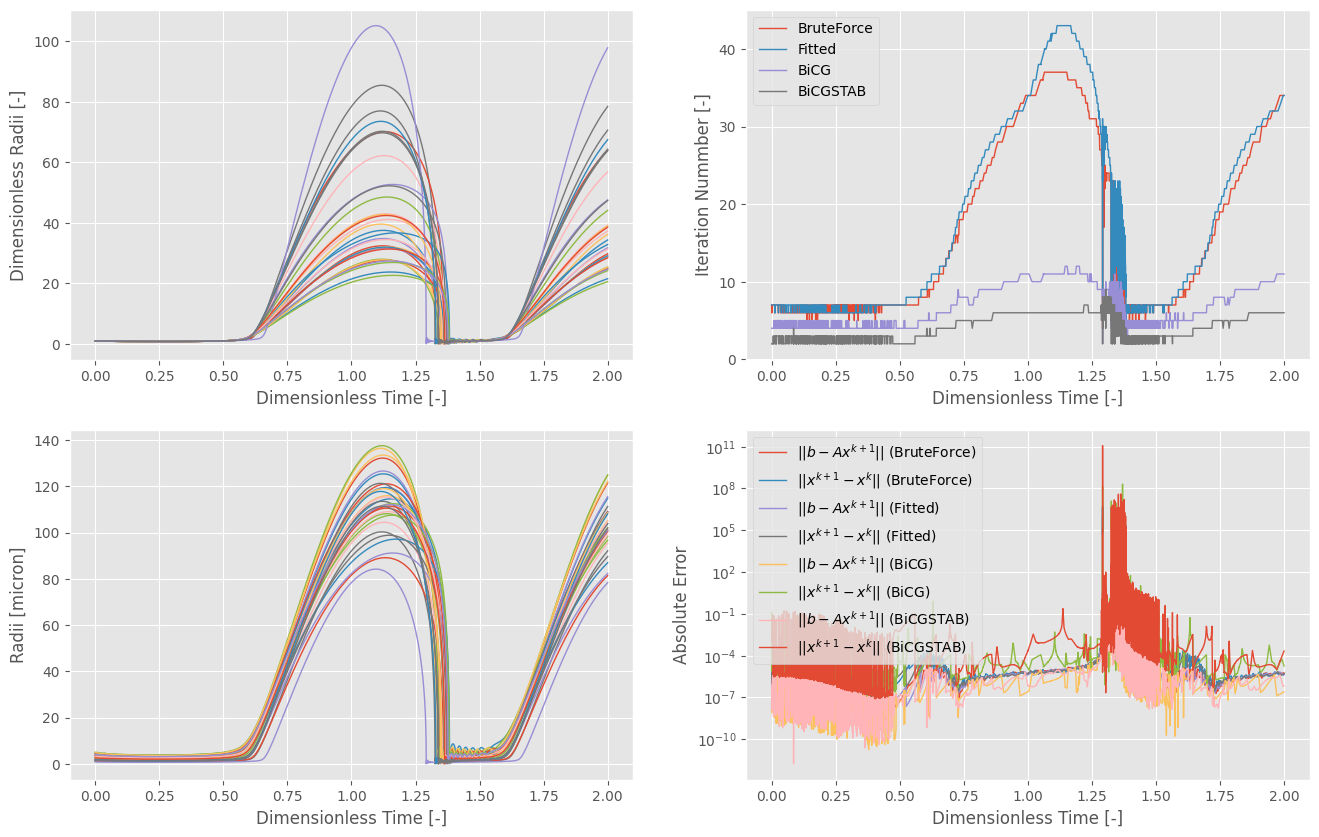

In [86]:
plot_figures(21, 2.6, 25.0)

# Runtime

In [81]:
def get_cluster_config(n, SEED):
    return f"N-{n:0.0f}-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-{SEED:.0f}"

def get_run_name(P1, P2):
    return f"P1-{P1:0.2f}-P2-{P2:0.2f}-P3-0.00-P4-0.00"

def load_runtime(seed, P1, P2):

    runtime_baseline = []
    runtime_fitted = []
    runtime_bicg = []
    runtime_bicgstab = []
    runtime_jacobi = []
    p = []
    for pa1 in P1:
        run_data = RUNTIME_DATA / get_cluster_config(32, seed) / get_run_name(pa1, P2)
        runtime_baseline.append(np.load(f"{run_data}_baseline.npz")["sim_time"])
        runtime_fitted.append(np.load(f"{run_data}_jacobi_fitted.npz")["sim_time"])
        runtime_bicg.append(np.load(f"{run_data}_bicg.npz")["sim_time"])
        runtime_bicgstab.append(np.load(f"{run_data}_bicgstab.npz")["sim_time"])
        try:
            runtime_jacobi.append(np.load(f"{run_data}_jacobi_baseline.npz")["sim_time"])
        except:
            runtime_jacobi.append(np.full(len(runtime_bicgstab[-1]), np.inf))
            print(pa1)
        p.extend([pa1] * len(runtime_bicgstab[-1]))  

    df = pd.DataFrame(
        {
            "P1" : p,
            "baseline" : np.hstack(runtime_baseline),
            "fitted" : np.hstack(runtime_fitted),
            "bicg" : np.hstack(runtime_bicg),
            "bicg_stab" : np.hstack(runtime_bicgstab),
            "jacobi" : np.hstack(runtime_jacobi)
        }
    )

    return df

df = load_runtime(21, [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0], 25.0)
df.head(5)
#print(df.shape)

2.2
2.4
2.6
2.8
3.0


P1  baseline    fitted      bicg  bicg_stab    jacobi
0  0.2  1.351749  1.269794  1.374399   1.259060  1.307882
1  0.2  1.342647  1.286344  1.363667   1.242971  1.300970
2  0.2  1.329475  1.274656  1.372781   1.247052  1.297246
3  0.2  1.329702  1.355495  1.374731   1.242738  1.306782
4  0.2  1.324606  1.393355  1.375378   1.250649  1.305457

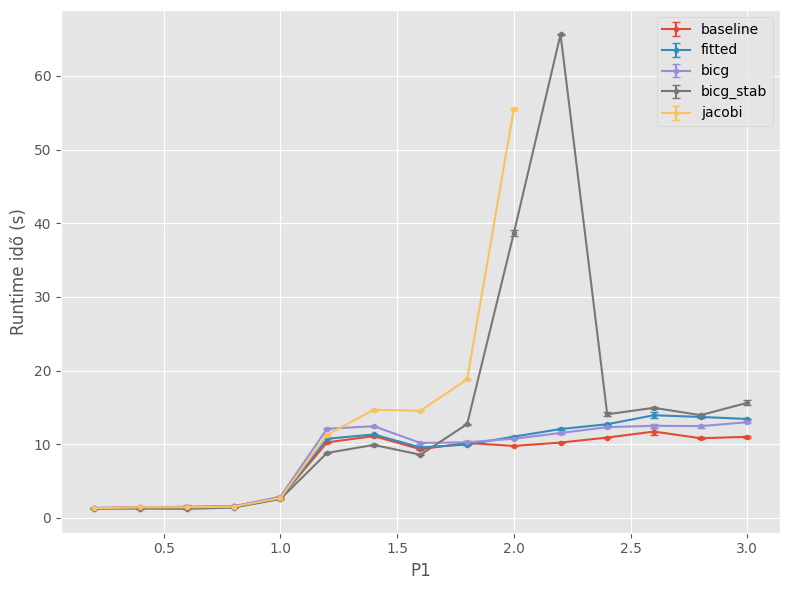

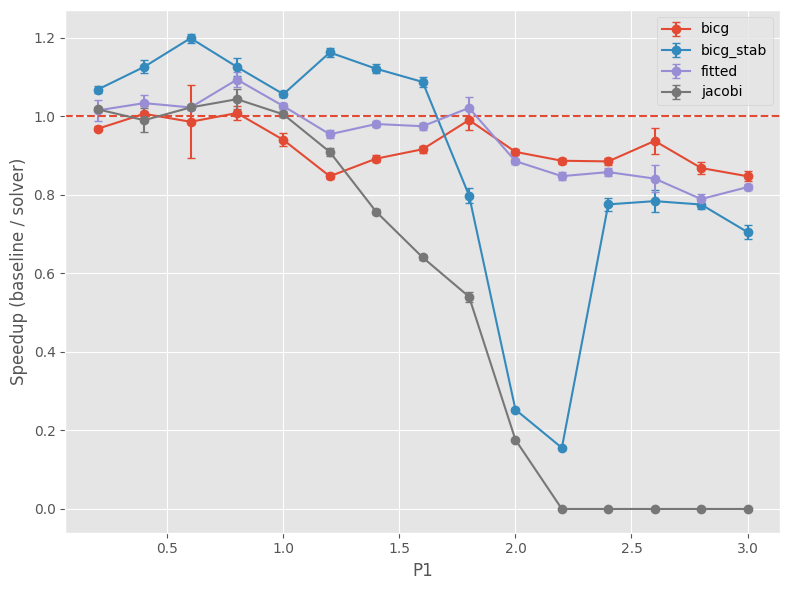

In [83]:

from scipy.stats import t

solvers = ["baseline", "fitted", "bicg", "bicg_stab", "jacobi"]

# Hosszú formátum
long = df.melt(id_vars="P1",
               value_vars=solvers,
               var_name="solver", value_name="time")

# 1) Skálázás: átlag + 95% CI hibasáv
stats = (long
         .groupby(["P1","solver"])
         .agg(mean=("time","mean"),
              std=("time","std"),
              n=("time","size"))
         .reset_index())
stats["tcrit"] = t.ppf(0.975, df=stats["n"] - 1)
stats["ci95"] = stats["tcrit"] * stats["std"] / np.sqrt(stats["n"])

with plt.style.context("ggplot"):
    plt.figure(figsize=(8, 6))
    for s in solvers:
        sub = stats[stats["solver"] == s].sort_values("P1")
        plt.errorbar(sub["P1"], sub["mean"], yerr=sub["ci95"],
                    marker=".", capsize=3, label=s)
    #plt.xscale("log", base=2)           # ha 4,8,16,32,64 → praktikus
    #plt.yscale("log")
    plt.xlabel("P1")
    plt.ylabel("Runtime idő (s)")
    plt.legend()
    plt.tight_layout()


# 2) Speedup a baseline-hoz képest (átlag + 95% CI)
speedup_frames = []
for s in solvers:
    if s == "baseline":
        continue
    sp = pd.DataFrame({
        "P1": df["P1"],
        "solver": s,
        "speedup": df["baseline"] / df[s]
    })
    speedup_frames.append(sp)
speedup = pd.concat(speedup_frames, ignore_index=True)

sp_stats = (speedup
            .groupby(["P1","solver"])
            .agg(mean=("speedup","mean"),
                 std=("speedup","std"),
                 n=("speedup","size"))
            .reset_index())
sp_stats["tcrit"] = t.ppf(0.975, df=sp_stats["n"] - 1)
sp_stats["ci95"] = sp_stats["tcrit"] * sp_stats["std"] / np.sqrt(sp_stats["n"])

with plt.style.context("ggplot"):
    plt.figure(figsize=(8, 6))
    for s in sp_stats["solver"].unique():
        sub = sp_stats[sp_stats["solver"] == s].sort_values("P1")
        plt.errorbar(sub["P1"], sub["mean"], yerr=sub["ci95"],
                    marker="o", capsize=3, label=s)
    plt.axhline(1.0, linestyle="--")  # 1 fölött gyorsabb a baseline-nál
    #plt.xscale("log", base=2)
    plt.xlabel("P1")
    plt.ylabel("Speedup (baseline / solver)")
    plt.legend()
    plt.tight_layout()

    plt.show()